## <center> **<span style="color: red">NLP</span> steps and explnation.**

Here we will use <span style="color: #ffd21e">**Hugging face**</span> trasformers pre trained models becuase it'll take so much effort to label<br>
all of our text columns "<ins>Comments, Describtion, Title</ins>" and also we will extract categorical and numirecal<br>
features from the text columns.<br><br>

##### **Steps in detail:**
<ul>
    <li>Extract categorical features from text columns sush as:<ol> 
        <li>Contains emojies
        <li>Positive or negative
        <li>Language
        <li>Video stats range</ol>
    <li> Doing analysis for most common words in comments and titles (Word cloud)
    <li> Extracing the length of the comments, descriptions & titles
    <li> One hot encoding
    <li> Stemming the data and tokenizing it
    <li> Saving those new data into new <strong>one</strong> Df to use in the final ML model

##### **Important note:**
The data in this analysis may be a little bit biased becuase all comments is made to be at least more than <br>
$50$.

## <center> **Importing the <span style="color: red">Packeges</span>**<br>

In [76]:
import re
import os
import ast
import time
import nltk
import emoji
import pickle
import sqlite3
import numpy as np

import scipy.stats
import pandas as pd
import transformers

from PIL import Image
import huggingface_hub
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from IPython.display import display, Markdown
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from IPython.display import set_matplotlib_formats
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, log_loss, accuracy_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from wordcloud import (WordCloud,
                       STOPWORDS,
                       ImageColorGenerator)

In [2]:
with open("../Data analysis/functions/z-score.pickle", "rb") as f:
    z_score = pickle.load(f)

%matplotlib inline
huggingface_hub.notebook_login()
set_matplotlib_formats('pdf', 'svg')

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_18696\3753516804.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## <center> **Reading the <span style="color: red">data</span>**

In [5]:
TEXT_COLUMNS = ["title", "comments", "description", "channelTitle", "about"]
NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',
            'uint16', 'uint32', 'uint64', float, int]

con = sqlite3.connect('../database.db')

df = pd.read_sql_query("""

                        SELECT *
                        FROM base_videos AS bv

                        INNER JOIN base_channels  AS bc ON
                            bc.channel_name = bv.channelTitle

                        INNER JOIN comments  AS c ON
                            c.video_id = bv.video_id""", con)

con.close()

df = df.T.drop_duplicates().T # dropping duplicated cols

In [6]:
df = df.sample(100)

##  <center> **Extract <span style="color: red">categorical</span> features**

#### *Extract emojies count per text*

In [7]:
comments_emojis_counts: list = []
title_emojis_counts: list = []
desc_emojis_counts: list = []

for comment, title, desc in zip(df["comments"], df["title"], df["description"]):
    
    comments_emojis_count: int = 0
    title_emojis_count: int = 0
    desc_emojis_count: int = 0
    
    for comment_char, title_char, desc_char in zip(comment, title, desc):
        
        if emoji.is_emoji(comment_char):
            comments_emojis_count += 1
            
        if emoji.is_emoji(title_char):
            title_emojis_count += 1
            
        if emoji.is_emoji(desc_char):
            desc_emojis_count += 1
    
    comments_emojis_counts.append(comments_emojis_count)
    title_emojis_counts.append(title_emojis_count)
    desc_emojis_counts.append(desc_emojis_count)

In [8]:
df["comments_emojis_count"] = comments_emojis_counts
df["title_emojis_count"] = title_emojis_counts
df["desc_emojis_count"] = desc_emojis_counts

df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,...,date,video_count,about,country,comments,like_counts,reply_counts,comments_emojis_count,title_emojis_count,desc_emojis_count
3546,62_usS0JuwM,Redux Gaming,PARADUZE zijn NIEUWE GAME PC Bouwen 😍 Gigabyte...,#nvidia #nvidiareflex #frameswingames \n\nPara...,"['game pc bouwen', 'paraduze fortnite', 'fortn...",2022-12-30 15:23:08+00:00,44964,553,101,hd,...,2019-09-13 00:00:00,351,Redux Gaming houdt jou op de hoogte van de laa...,NL,"Ik ben voor een 5000 euro pc aan het sparen, (...",1,0,0,1,0
225,ylCMRMOGylA,ERWIN GAMING,ကလေးလူမိုက်ကြီး အသည်းကွဲပီ💔💔💔 GTA V Baby Gang ...,GTA V\nGTA 5\nGTA V Myanmar\nGTA 5 Myanmar\nGT...,"['GTA V', 'GTA 5', 'GTA 5 Myanmar', 'GTA 5 Rol...",2023-01-26 08:35:26+00:00,180964,2635,224,hd,...,2021-10-17 00:00:00,382,I like playing games with mods. 😁☺️,SG,ကားလက်သွားလေ,0,1,0,0,0
5818,Ueb8AhQQpyM,JOJO Gaming,فيلم روبلوكس : ميجو 9 اتحبس في مسلسلات رمضان 😱,#فيلم_روبلوكس_جديد\n#فيلم_روبلوكس_بنات\n#فيلم_...,"['#فيلم_روبلوكس_حزين', '#فيلم_روبلوكس_رعب', '#...",2023-04-06 19:03:31+00:00,34687,3055,91,hd,...,2021-05-25 00:00:00,464,هاي يا اصدقائى \nبحبكو جدا انا جوجو بحب لعبة ر...,AE,#مافيا_الجامدين,0,0,0,0,0
5871,mUrj4NMxIz0,Teddy Gaming,😈TEDDY SMP IS IN BIG TROUBLE - TEDDY GAMING PA...,💥Instagram:-https://www.instagram.com/masterxa...,"['teddy gaming', 'teddy smp', 'teddy gaming he...",2023-03-15 16:29:46+00:00,158454,11722,305,hd,...,2020-10-08 00:00:00,238,Please Press This Red Button🥺\n\nONLY UNIQUE A...,IN,Teddy bahi🎉 16000ki super chat,0,0,1,1,1
657,W-kp9pAmztE,Aly & Toty Gaming,فيلم | وجدت شبح طيب فى بيتنا الجديد وقررت أساعده,فيلم | وجدت شبح طيب فى بيتنا الجديد وقررت أساع...,"['Roblox', 'games', 'fun', 'story', 'stories',...",2023-03-12 15:00:31+00:00,102267,3226,398,hd,...,2020-06-13 00:00:00,427,احنا عيلة بسيطة وعندنا حلم كبير بنحب نلعب روبل...,EG,👻😍🥰😘😊☺️ينفتحا,0,0,6,0,0


#### *Language detection*

In [36]:
language_detector = transformers.pipeline("text-classification",
                                          model="papluca/xlm-roberta-base-language-detection",
                                          use_auth_token= True)

In [37]:
%%timeit
print(language_detector("هذا أطول نص قد تقرأه على الإطلاق إنه طويل للغاية", max_length=128))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
2.19 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like we will take a lot to <ins>just classify the language</ins> of each text at least: $30\times100$ second whitch equalls <span style="color: red">**50 minutes.**</span><br>
So we can't do translation for now becuase it at least may take **5 hours** to run so we will just use this language detetion and<br>
optimize it by just sellecting one text column to detect which will be **Description column** and use the detected languages to<br>
pridect video and comments language.<br><br>
But we will detect the language using the **country of this video**

In [9]:
df["country"].unique()

array(['US', 'CA', 'PK', 'IN', 'VN', 'BR', 'NL', 'PH', 'ID', 'KR', 'RU',
       'EG', 'FI', 'AE', 'AU', 'GB', 'RO', 'SA', 'DZ', 'TH', 'SG', 'TR'],
      dtype=object)

In [10]:
country_languages = {
    'DE': 'German',
    'US': 'English', 'PL': 'Polish',
    'SA': 'Arabic', 'NP': 'Nepali',
    'CA': 'English', 'ES': 'Spanish',
    'TR': 'Turkish', 'IN': 'Hindi',
    'EG': 'Arabic', 'GB': 'English',
    'MX': 'Spanish', 'BR': 'Portuguese',
    'PK': 'Urdu', 'FR': 'French',
    'VN': 'Vietnamese', 'ID': 'Indonesian',
    'AU': 'English', 'HU': 'Hungarian',
    'NL': 'Dutch', 'BG': 'Bulgarian',
    'JP': 'Japanese', 'SG': 'English', 
    'TH': 'Thai', 'PH': 'Tagalog',
    'MT': 'Maltese', 'PE': 'Spanish',
    'SE': 'Swedish', 'IT': 'Italian',
    'KR': 'Korean', 'TW': 'Chinese',
    'FI': 'Finnish', 'DZ': 'Arabic',
    'BD': 'Bengali', 'AR': 'Spanish'}

df["language"] = df["country"].replace(country_languages)

This way may not be so accurate in detecting languages becuase there are some **indian videos** specifically with english and<br>
because some commetns come in deffrint languages but at least this way is more accurate than `roberta-language-detection`<br>
model because this model sometimes come with wierd.

#### *Sentiment analysis*

In [11]:
sentiment_classifier = transformers.pipeline(model= "finiteautomata/bertweet-base-sentiment-analysis")
print(sentiment_classifier("Hello here in my analysis, Have a nice day !!"))

Downloading:   0%|          | 0.00/2.68k [00:00<?, ?B/s]

[{'label': 'POS', 'score': 0.9883897304534912}]


In [12]:
def my_sentiment_classifier(text: str) -> np.int8:
    """This code takes a text and return you if it's positive
        or negative as 1 for positive, 0 for natural -1 for negative
        and -10 for unclassified.
    
    @params: a string text
    @return: 1, 0 or -1 in np.int8 dtype"""
    
    global sentiment_type_encoder
    
    sentiment_type_encoder = {"POS": 2,
                              "NEG": -1,
                              "NEU": 1,
                              "unclassified": 0}
    
    try:
        sentiment_type: str = sentiment_classifier(text)[0]["label"]

    except Exception as e:
        sentiment_type: str = "unclassified"

    return  np.int8(sentiment_type_encoder[sentiment_type])

In [13]:
df["comments_sentiments"] = df["comments"].apply(
    lambda x: my_sentiment_classifier(x))

df[["comments_sentiments", "comments"]][:5]

,comments_sentiments,comments
4453,2,Quattro baseball is incredible!
3579,1,13:01 PUSH THE PLANK U NUMBSKULL
1270,1,"Luke,i have a pro tip:USE A GODDAMN SHIELD"
1555,1,Mubarak ho bhao 100k sub...
3055,2,Wow you mentioned kerbal. They were the openin...


Now we will drop the comments column becuase we already have done the **sentiment analysis** process.<br>
so now we'll group the data by the `video_id` column.

##### **Important note:** 
We will create other **data frame** to store the comments <ins>temporary</ins> so we can create our comments<br>
**WordCloud**.

In [14]:
comments_cols = ['video_id', 'reply_counts', 'comments_sentiments',
                 'like_counts', "comments_emojis_count"]

temp_comments_df = df[["comments", "language", "title"]].copy()


# Here we will groupby the sentiments to be just one feature
comments_sentiments = df[comments_cols].copy()
comments_sentiments = comments_sentiments.groupby("video_id").sum().reset_index()
comments_sentiments.rename(columns= {"comments_sentiments": "sentiments"}, inplace= True)

    
df.drop(comments_cols[1:] + ["comments"],
        axis= 1, inplace= True)

df.drop_duplicates(inplace= True)
df.reset_index(inplace= True)
df.drop(["index"], axis= 1, inplace= True)


del TEXT_COLUMNS[1] # "comments" element

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_18696\2773865321.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  comments_sentiments = comments_sentiments.groupby("video_id").sum().reset_index()


In [15]:
display(Markdown(f"The length of `comments_sentiments` dataframe is ${len(comments_sentiments)}$ " + \
                 f"and also the length of the main dataframe is ${len(df)}$ so every thing is <br>working fine "))

The length of `comments_sentiments` dataframe is $82$ and also the length of the main dataframe is $84$ so every thing is <br>working fine 

In [16]:
df = pd.merge(df, comments_sentiments, on='video_id', how= 'outer')

df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,...,total_views,date,video_count,about,country,title_emojis_count,desc_emojis_count,language,sentiments,comments_emojis_count
0,_eG-PSZU5MI,Gaming Historian,Aladdin Deck Enhancer | Gaming Historian,Learn about the history of a unique NES access...,"['Aladdin Deck Enhancer', 'Camerica', 'Codemas...",2019-02-21 18:30:09+00:00,1366274,30940,3098,hd,...,124399915,2006-07-17 00:00:00,142,The Gaming Historian is a documentary series a...,US,0,0,English,2,0
1,9Igdu5aMncs,Justmaiko Gaming,THE CRAZIEST. ENDING. EVER. | Little Nightmare...,JOIN MY DISCORD TO PLAY GAMES & CHAT WITH ME!:...,"['little night mares 2', 'lln2', 'little night...",2021-03-06 17:17:51+00:00,824913,9701,1147,hd,...,71577192,2020-10-21 00:00:00,31,,US,0,0,English,1,0
2,KnkQK_8EFno,Luke Davidson Gaming,I Found The End Portal In Minecraft (Part 21),In todays video I continue my Minecraft Lets P...,[],2021-12-04 01:00:05+00:00,167240,5504,813,hd,...,28133386,2021-05-18 00:00:00,54,You may know me from my main channel @Luke Dav...,CA,0,0,English,1,0
3,TDLB4o0ys70,HaBiB GaMinG,"100,000 Subs Complete Plans | Hip Hop Bundle R...","The Video Is About 100,000 Subs Complete Plans...","['100k Subs Complete Plans', 'Hip Hop Bundle R...",2023-04-08 15:03:07+00:00,9250,1586,455,hd,...,8488456,2019-12-31 00:00:00,873,★ Intro ★ \nHi Viewers My Name Is Ha...,PK,0,0,Urdu,1,0
4,Bu100EOtdJI,kAN Gaming,Building Rockets in the Space Sandbox Juno: Ne...,Hey everyone and welcome to Juno: New Origins!...,"['kan gaming', 'juno: new origins', 'new space...",2023-02-15 23:32:08+00:00,20698,1418,131,hd,...,154452839,2016-01-01 00:00:00,1496,Video games for life!\n\n\n,CA,0,0,English,2,0


#### *Video stats range*

We will classify each column of **[Comments, Likes, Views]** into 6 groups manually like:
<ul>
    <li>  $1\sim3,000$ Views
    <li>  $3,000\sim10,000$ Views
    <li>  $10,000\sim50,000$ Views
    <li>  $50,000\sim100,000$ Views
    <li>  $100,000\sim300,000$ Views
    <li>  $300,000\sim\infty$



We will see the max calues of each column so we can optimize it with the best dtype for it.

In [17]:
print(f" The max value of view count column is: {df['viewCount'].astype(int).max()}\n",
      f"The max value of like count column ias: {df['likeCount'].astype(int).max()}\n",
      f"The max value of comment count column is: {df['commentCount'].astype(int).max()}\n",
      f"The max value of subscribers column is: {df['subscribers'].astype(int).max()}\n")

 The max value of view count column is: 6631512
 The max value of like count column ias: 201260
 The max value of comment count column is: 9151
 The max value of subscribers column is: 13500000



In [18]:
df = df.astype({"commentCount": np.uint16, "viewCount": np.uint32,
                "likeCount": np.uint16, "subscribers": np.uint32})

df.describe()

,viewCount,likeCount,commentCount,subscribers,title_emojis_count,desc_emojis_count,sentiments,comments_emojis_count
count,8.400000e+01,84.000000,84.000000,8.400000e+01,84.000000,84.000000,84.000000,84.000000
mean,4.728565e+05,9666.821429,739.154762,1.731293e+06,0.119048,0.107143,1.321429,1.809524
std,1.101889e+06,12903.762122,1452.627561,2.973901e+06,0.360881,0.380800,0.880316,8.332656
min,7.374000e+03,428.000000,52.000000,6.720000e+03,0.000000,0.000000,-1.000000,0.000000
25%,4.350775e+04,1813.000000,142.000000,3.247500e+05,0.000000,0.000000,1.000000,0.000000
50%,1.141260e+05,4238.500000,300.500000,6.000000e+05,0.000000,0.000000,1.000000,0.000000
75%,2.693142e+05,10554.250000,634.250000,1.862500e+06,0.000000,0.000000,2.000000,0.000000
max,6.631512e+06,55011.000000,9151.000000,1.350000e+07,2.000000,2.000000,4.000000,54.000000


In [19]:
df["cat_view_count"] = pd.cut(df['viewCount'],
                         bins=[1, 3_000, 10_000, 50_000, 100_000, 300_000, 999_999_999_999],
                         labels=["from 1 to 3,000", "from 3,000 to 10,000",
                                 "from 10,000 to 50,000", "from 50,000 to 100,000",
                                 "from 100,000 to 300,000", "more than 300,000"])

df["cat_comment_count"] = pd.cut(df['commentCount'],
                         bins=[50, 100, 150, 200, 400, 600, 999_999_999_999],
                         labels=["from 50 to 100", "from 100 to 150",
                                 "from 150 to 200", "from 200 to 400",
                                 "from 400 to 600", "more than 600"])

df["cat_like_count"] = pd.cut(df['likeCount'],
                         bins=[0, 1_000, 5_000, 10_000, 50_000, 150_000, 999_999_999_999],
                         labels=["from 1 to 1,000", "from 1,000 to 5,000",
                                 "from 5,000 to 10,000", "from 10,000 to 50,000",
                                 "from 50,000 to 150,000", "more than 150,000"])

In [20]:
df[["cat_view_count", "cat_comment_count", "cat_like_count",
    "viewCount", "commentCount", "likeCount"]].sample(5)

,cat_view_count,cat_comment_count,cat_like_count,viewCount,commentCount,likeCount
32,"from 100,000 to 300,000",more than 600,"from 10,000 to 50,000",212753,927,10972
71,"from 10,000 to 50,000",from 50 to 100,"from 1,000 to 5,000",11077,59,1511
31,"from 100,000 to 300,000",from 200 to 400,"from 1,000 to 5,000",128886,203,2546
58,"from 50,000 to 100,000",from 200 to 400,"from 1,000 to 5,000",61007,281,1178
57,"from 100,000 to 300,000",from 200 to 400,"from 1,000 to 5,000",102267,398,3226


#### *Text columns length*

In [21]:
for col in TEXT_COLUMNS:
    df[f"{col}_length"] = df[col].str.len()
    df[f"{col}_length"] = df[f"{col}_length"].astype(np.uint16)

## <center><strong>Text visualiztion with<span style = "color: red"> WordCloud</span></strong></center>

In [22]:
coloring = np.array(Image.open("../imgs/youtube_gaming_logo.png"))
stopwords = set(STOPWORDS)

comments = ''.join(
    temp_comments_df["comments"][temp_comments_df["language"] == "English"].values.flatten())

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


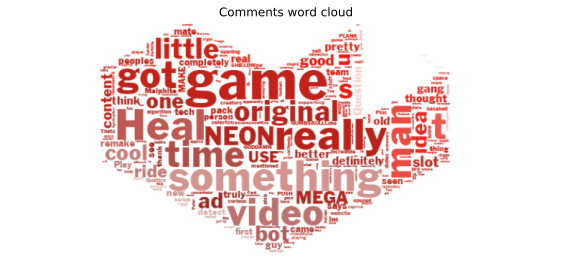

In [23]:
comments_wc = WordCloud(background_color= "white", max_words= 300, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf',
               collocations=False)

image_colors = ImageColorGenerator(np.array(coloring))
comments_wc.generate(comments)
comments_wc = comments_wc.recolor(color_func= image_colors)

comments_svg = comments_wc.to_svg(embed_font=True)

# Save the SVG code to a file
with open("../plots/comments_word_cloud.svg", "w", encoding="utf-8") as f:
    f.write(comments_svg)
    
fig, ax = plt.subplots(1)

ax.imshow(comments_wc, interpolation="bilinear")
ax.set_axis_off()

plt.title("Comments word cloud")
fig.set_size_inches(10, 8)
plt.savefig("../plots/comments_word_cloud.png")
plt.show()

Now we will make a word cloud for **video titles data**

In [24]:
popular_emojis = ["😊", "😍", "😘", "😜", "😝", "😂", "😭", "😡", "😠", "😩", "😫", "😞", "😟", "😢", "😥", "😰", "😱",
                       "😳", "😷", "👍", "👎", "👌", "👏", "🙌", "👋", "💪", "🙏", "❤️", "💔", "💕", "💖", "💘", "💙", "💚",
                       "💛", "💜", "💯", "🔥", "🌟", "✨", "⭐", "🌈", "🌺", "🍕", "🍔", "🍟", "🍦", "🍭", "🍩", "🍪", "🍺",
                       "🍻", "🍷", "🍸", "🎂", "🎁", "🎉", "🎊", "🎈", "🎵", "🎶", "🎼", "🎧", "🎤", "🎸", "🎹", "🎺", "🎷",
                       "🎻", "🎬", "🎥", "🎦", "📷", "📹", "📺", "📻", "💻", "📱", "💡", "🔑", "🔨", "🔥", "💰", "💳", "💼",
                       "📅", "📆", "📈", "📉", "📊", "📋", "📎", "📏", "📐", "🔒", "🔓", "🔍", "🔎", "🚀", "🚑", "🚒", "🚓",
                       "🚕", "🚗", "🚙", "🚚", "🚢", "🚤", "🚲", "🚶", "🚶‍♀️", "🏃", "🏃‍♀️", "⚽", "🏀", "🏈", "🎾", "🏐", "🏉",
                       "🎱", "🏓", "🏸", "🥊", "🥋", "🎮", "🕹️", "🎲", "🃏"]


for emoji in popular_emojis:
    stopwords.add(emoji)
    
titels = ''.join(
    temp_comments_df["title"][temp_comments_df["language"] == "English"].values.flatten())

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


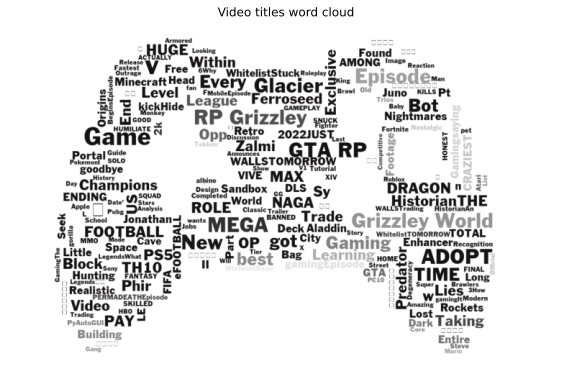

In [25]:
coloring = np.array(Image.open("../imgs/joystick.png"))

titels_wc = WordCloud(background_color= "white", max_words= 2000, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf')

titels_wc.generate(titels)
image_colors = ImageColorGenerator(np.array(coloring))
titels_wc = titels_wc.recolor(color_func= image_colors)


fig, ax = plt.subplots(1)

ax.imshow(titels_wc, interpolation= "bilinear")
ax.set_axis_off()

titels_svg = titels_wc.to_svg(embed_font=True)

with open("../plots/videos_titels_word_cloud.svg", "w", encoding="utf-8") as f:
    f.write(titels_svg)

plt.title("Video titles word cloud")
fig.set_size_inches(10, 8)
plt.savefig("../plots/videos_titels_word_cloud.png")
plt.show()

In [26]:
del temp_comments_df

## <center><strong><span style = "color: red">NLP</span> preprocessing

#### *Removing stop words*

In [27]:
from nltk.corpus import stopwords
# nltk.download()

nltk.download('punkt', force=True)
nltk.download('wordnet', force= True)
nltk.download('stopwords', force=True)
nltk.download('stopwords-hi', force=True)
nltk.download('stopwords-ar', force=True)
nltk.download('averaged_perceptron_tagger', force=True)


en_stopwords = set(stopwords.words('english')) 
ar_stopwords = set(stopwords.words('arabic')) 
# hi_stopwords = set(stopwords.words('hindi')) 

all_stopwords = en_stopwords.union(ar_stopwords)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FreeComp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FreeComp\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FreeComp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Error loading stopwords-hi: Package 'stopwords-hi' not
[nltk_data]     found in index
[nltk_data] Error loading stopwords-ar: Package 'stopwords-ar' not
[nltk_data]     found in index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\FreeComp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [28]:
def stopwords_dropper(words: list, stopwords: set) -> list:
    
    # Removing stop words from unalphabetical chars
    filtered_words = [re.sub(r"[\W_]", "", word) for word in words
                      if not word in stopwords]
    
    filtered_words = list(filter(lambda item: item != "", filtered_words))
    return  filtered_words


for col in TEXT_COLUMNS:
    df[f"{col}_tokens"] = df[col].apply(lambda text: nltk.word_tokenize(text.lower()))
    df[f"{col}_tokens"] = df[f"{col}_tokens"].apply(lambda text: stopwords_dropper(text,
                                                                     all_stopwords))

df["title_tokens"]

0          [aladdin, deck, enhancer, gaming, historian]
1     [craziest, ending, ever, little, nightmares, i...
2             [found, end, portal, minecraft, part, 21]
3     [100000, subs, complete, plans, hip, hop, bund...
4     [building, rockets, space, sandbox, juno, new,...
                            ...                        
79    [mirchi, challenge, usne, mujhe, noob, bola, c...
80    [teddy, smp, big, trouble, teddy, gaming, park...
81      [story, super, mario, world, gaming, historian]
82    [ailece, para, kazandik, sims, 4, 100, bebek, ...
83    [last, us, hbo, show, official, trailer, react...
Name: title_tokens, Length: 84, dtype: object

#### *Part-of-speech (POS) Tagging*

In [29]:
for col in TEXT_COLUMNS:
    df[f"{col}_pos_tags"] = df[f"{col}_tokens"].apply(lambda words: nltk.pos_tag(words))

df["about_pos_tags"]

0     [(gaming, VBG), (historian, JJ), (documentary,...
1                                                    []
2     [(may, MD), (know, VB), (main, JJ), (channel, ...
3     [(intro, JJ), (hi, NN), (viewers, NNS), (name,...
4               [(video, NN), (games, NNS), (life, NN)]
                            ...                        
79    [(hey, NN), (guys, NNS), (rishi, VBP), (kumar,...
80    [(please, VB), (press, NN), (red, JJ), (button...
81    [(gaming, VBG), (historian, JJ), (documentary,...
82    [(daha, NN), (fazla, NN), (oyun, NN), (daha, N...
83    [(hi, NN), (m, NN), (bri, VBD), (welcome, JJ),...
Name: about_pos_tags, Length: 84, dtype: object

#### *Lemmatization and dropping duplicated words*

In [30]:
def get_wordnet_pos(treebank_tag: str) -> str:
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN

In [31]:
lemmatizer = WordNetLemmatizer()
lemmatized_words = []
lemmatized_words_group = []

for col in TEXT_COLUMNS:
    for index, row in df.iterrows():
        for token, pos_tag in zip(row[f"{col}_tokens"], row[f"{col}_pos_tags"]):

            wordnet_pos = get_wordnet_pos(pos_tag[1])
            lemmatized_words_group.append(lemmatizer.lemmatize(token, pos= wordnet_pos))
            lemmatized_words_group = list(set(lemmatized_words_group)) # Dropping duplicates


        lemmatized_words.append(lemmatized_words_group)
        lemmatized_words_group = [] # clearing this list
    
    df[f"{col}_tokens"] = lemmatized_words
    lemmatized_words = []

In [32]:
df["channelTitle_tokens"][:5]

0           [historian, game]
1         [justmaiko, gaming]
2    [gaming, davidson, luke]
3             [habib, gaming]
4               [kan, gaming]
Name: channelTitle_tokens, dtype: object

#### *One hot encoding*

In [41]:
df["language"] = df["language"].astype("category").cat.codes
df["definition"] = df["definition"].astype("category").cat.codes
df["country"] = df["country"].astype("category").cat.codes
df["sentiments"] = df["sentiments"].astype(np.int8)

df["cat_view_count"] = df["cat_view_count"].replace({"from 1 to 3,000": 1, "from 3,000 to 10,000": 2,
                                                     "from 10,000 to 50,000": 3, "from 50,000 to 100,000": 4,
                                                     "from 100,000 to 300,000": 5, "more than 300,000": 6})

df["cat_like_count"] = df["cat_like_count"].replace({"from 1 to 1,000": 1, "from 1,000 to 5,000": 2,
                                                     "from 5,000 to 10,000": 3, "from 10,000 to 50,000": 4,
                                                     "from 50,000 to 150,000": 5, "more than 150,000": 6})

df["cat_comment_count"] = df["cat_comment_count"].replace({"from 50 to 100": 1, "from 100 to 150": 2,
                                                           "from 150 to 200": 3, "from 200 to 400": 4,
                                                           "from 400 to 600": 5, "more than 600": 6})

In [42]:
df[["language", "definition", "cat_view_count",
    "cat_like_count", "cat_comment_count", "sentiments"]].sample(5)

,language,definition,cat_view_count,cat_like_count,cat_comment_count,sentiments
27,3,0,4,4,4,3
83,3,0,3,2,3,1
36,1,0,4,2,5,1
37,3,0,5,2,4,0
48,2,0,3,1,2,1


## <center><strong><span style = "color: red">Text</span> classification

#### *Preparing training & testing data*

In [135]:
# Changing dtypes of some colums:hh
df = df.astype({"total_views": np.uint64, "video_count": np.uint16,
                "duration_in_minutes": np.float32, "date": "datetime64[ns]",
                "publishedAt": "datetime64[ns]"})


# Those are just temporary text columns not the main one.
text_cols = ["tags", "about_tokens", "title_tokens",
             "channelTitle_tokens", "description_tokens"]

cat_cols = ["country", "language", "definition"]

numeric_cols = [*df.select_dtypes(NUMERICS).columns]

target_cols = ["cat_view_count", "cat_like_count", "cat_comment_count"]

date_cols = ["date", "publishedAt"]



X = df[numeric_cols + cat_cols + date_cols + text_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 2/5, random_state= 99)

print(f"The shape of the X train data is: {X_train.shape}")
print(f"The shape of the X test data is: {X_test.shape}")
print(f"The shape of the y train data is: {y_train.shape}")
print(f"The shape of the y test data is: {y_test.shape}")

del X, y

The shape of the X train data is: (50, 24)
The shape of the X test data is: (34, 24)
The shape of the y train data is: (50, 3)
The shape of the y test data is: (34, 3)


Now we need to save the **features** and **targets** **labels flow** so we understand the inputs and outputs for the model.<br>

In [136]:
# X_trainX_train.columns
X_train_labels = {index: value for index, value in enumerate(X_train.columns)}
X_test_labels = {index: value for index, value in enumerate(X_test.columns)}

y_train_labels = {index: value for index, value in enumerate(y_train.columns)}
y_test_labels = {index: value for index, value in enumerate(y_test.columns)}

X_train_labels

{0: 'viewCount',
 1: 'likeCount',
 2: 'commentCount',
 3: 'duration_in_minutes',
 4: 'subscribers',
 5: 'total_views',
 6: 'video_count',
 7: 'title_emojis_count',
 8: 'desc_emojis_count',
 9: 'comments_emojis_count',
 10: 'title_length',
 11: 'description_length',
 12: 'channelTitle_length',
 13: 'about_length',
 14: 'country',
 15: 'language',
 16: 'definition',
 17: 'date',
 18: 'publishedAt',
 19: 'tags',
 20: 'about_tokens',
 21: 'title_tokens',
 22: 'channelTitle_tokens',
 23: 'description_tokens'}

#### *preprocessing*

https://towardsdatascience.com/how-to-combine-textual-and-numerical-features-for-machine-learning-in-python-dc1526ca94d9

In [137]:
text_cols

['tags',
 'about_tokens',
 'title_tokens',
 'channelTitle_tokens',
 'description_tokens']

In [138]:
for X in X_train, X_test:
    
    for col in X[text_cols].columns:
        X[col] = X[col].astype(str)
        
    X["stacked_text"] = X[text_cols].agg(', '.join, axis=1).astype(str)
    X["stacked_text"] = X["stacked_text"].str.replace("[", "")
    X["stacked_text"] = X["stacked_text"].str.replace("]", "")

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_18696\31253900.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("[", "")
C:\Users\FreeComp\AppData\Local\Temp\ipykernel_18696\31253900.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("]", "")
C:\Users\FreeComp\AppData\Local\Temp\ipykernel_18696\31253900.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("[", "")
C:\User

In [139]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
vectorizer = CountVectorizer()

for X in X_train, X_test:
            
    X["stacked_text"] = X[text_cols].agg(', '.join, axis=1).astype(str)
    X["stacked_text"] = X["stacked_text"].str.replace("[", "")
    X["stacked_text"] = X["stacked_text"].str.replace("]", "")
    
    numeric_cols_arr = scaler.fit_transform(X[numeric_cols])
    cat_cols_arr = X[cat_cols].to_numpy()
    text_col_arr = vectorizer.fit_transform(X["stacked_text"]).mode(axis=1)
    
    
    if X.shape == X_train.shape:
        
        X_train = np.asarray(np.hstack((numeric_cols_arr,
                    cat_cols_arr, text_col_arr)))
        
    elif X.shape == X_test.shape:
        
        X_test = np.asarray(np.hstack((numeric_cols_arr,
                            cat_cols_arr, text_col_arr)))
        
y_test = y_test.to_numpy().astype(int)
y_train = y_train.to_numpy().astype(int)

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_18696\3784117923.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("[", "")
C:\Users\FreeComp\AppData\Local\Temp\ipykernel_18696\3784117923.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("]", "")


AttributeError: mode not found

In [140]:
print(f" The shape of X train is: {X_train.shape}\n" + \
      f" The shape of X test is: {X_test.shape}\n" + \
      f" The shape of y train is: {y_train.shape}\n" + \
      f" The shape of y test is: {y_test.shape}.")

 The shape of X train is: (50, 25)
 The shape of X test is: (34, 25)
 The shape of y train is: (50, 3)
 The shape of y test is: (34, 3).


In [128]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.287102,-0.527352,-0.378141,1.287968,-0.340976,-0.204358,0.569333,-0.349563,-0.312737,-0.267907,1.596318,0.976007,1.578806,0.513802,20.0,3.0,0.0,0.062128
1,-0.251979,-0.427554,-0.257854,0.007753,0.205697,0.178452,0.116640,-0.349563,-0.312737,-0.267907,0.120010,-0.414967,0.671446,-0.186548,12.0,11.0,0.0,0.029081
2,0.324045,0.630271,0.363780,-0.438874,-0.216127,-0.361034,-0.778808,-0.349563,-0.312737,-0.267907,-1.308676,-0.597068,-0.538367,-1.200690,20.0,3.0,0.0,0.016523
3,5.569381,-0.336110,1.156203,-0.425840,0.050560,-0.252935,-0.832910,-0.349563,-0.312737,-0.267907,-0.832447,0.340053,1.881259,-0.486697,2.0,8.0,0.0,0.041309
4,-0.363636,-0.502925,0.207683,-0.323307,-0.481338,-0.419649,-0.520442,-0.349563,-0.312737,-0.267907,2.120169,0.333049,-0.235913,-1.173403,20.0,3.0,0.0,0.053206
5,-0.369350,-0.609897,-0.006262,-0.190941,-0.560118,-0.485755,-0.800890,-0.349563,-0.312737,-0.267907,-0.880070,-1.123761,1.578806,-1.073353,20.0,3.0,0.0,0.014210
6,-0.342246,-0.454615,-0.163278,-0.438005,-0.493527,-0.457211,-0.809723,-0.349563,-0.312737,-0.267907,0.691484,1.285579,-0.538367,1.928143,20.0,3.0,0.0,0.095836
7,-0.017465,0.187217,0.185646,-0.257848,0.205697,0.178452,0.116640,-0.349563,1.921098,4.826106,-0.213350,-0.414967,0.671446,-0.186548,12.0,11.0,0.0,0.029081
8,-0.251674,1.041450,-0.199088,-0.491878,0.925976,0.603274,0.859718,2.147318,-0.312737,-0.267907,-1.261053,-0.400959,0.368993,-0.263859,9.0,5.0,0.0,0.025116
9,0.035416,-0.333477,-0.318457,-0.268854,-0.052864,0.901248,-0.366968,-0.349563,-0.312737,-0.267907,-1.451544,-0.458391,-0.538367,0.713901,20.0,3.0,0.0,0.031395


In [129]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
classifier = MultiOutputClassifier(rf, n_jobs=-1)
classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=10), n_jobs=-1)

In [130]:
y_pred = classifier.predict(X_test)

In [134]:
y_pred

array([[3, 2, 2],
       [3, 1, 2],
       [3, 2, 4],
       [6, 4, 6],
       [3, 1, 2],
       [3, 2, 1],
       [5, 4, 4],
       [5, 4, 4],
       [4, 3, 4],
       [6, 4, 6],
       [5, 4, 4],
       [3, 2, 2],
       [3, 2, 2],
       [4, 4, 6],
       [5, 4, 4],
       [4, 2, 4],
       [3, 2, 4],
       [3, 1, 3],
       [3, 1, 1],
       [6, 4, 6],
       [3, 2, 3],
       [5, 3, 4],
       [6, 4, 6],
       [3, 2, 1],
       [3, 1, 2],
       [3, 2, 4],
       [6, 4, 6],
       [3, 1, 2],
       [6, 4, 6],
       [3, 2, 4],
       [3, 1, 1],
       [3, 2, 4],
       [4, 2, 4],
       [3, 2, 3]])

#### *Training the models*

In [132]:
classifier.score(X_test, y_test)

0.23529411764705882

In [133]:
def model_report(y_true, y_pred):

    pre = precision_score(y_true, y_pred, pos_label=1, average='binary')
    rec = recall_score(y_true, y_pred, average= "micro")
    f1 = f1_score(y_true, y_pred, average= "micro")
  # loss = log_loss(y_true, y_pred, normalize= False)
    acc = accuracy_score(y_true, y_pred)

    print("| precision: {:4f}        |\n".format(pre) + \
          "| recall: {:4f}           |\n".format(rec) + \
          "| f1-score: {:4f}         |\n".format(f1) + \
          "| accuracy: {:4f}         |".format(acc))

In [ ]:
model_report(y_true, y_pred)